# UWF22 dataset stats

This notebook explores the data from the UWF22 dataset

In this notebook, we explore:
- Basic dataset stats


### Prepare the dataset

Run the preparation for the dataset with the `prepare_data` and `setup` methods.

In [1]:
from datasets.UWF22_local import UWF22L
from ordered_set import OrderedSet

dataset = UWF22L("/data/datasets/UWF22")

dataset.prepare_data()
dataset.setup(stage="fit")

/data/Try1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output


def generate_maps():
    # Get dataset columns
    one_batch, _ = next(iter(dataset.generate_batches()))
    columns = list(one_batch[0].columns)

    # Generate keymaps
    exclude_columns = [
        "ts",
        "src_ip_id",
        "src_ip_zeek",
        "dest_ip_id",
        "dest_ip_zeek",
        "src_service_id",
        "dest_service_id"
    ]
    keyword_map = {col: OrderedSet([]) for col in columns if col not in exclude_columns}
    hostmap = OrderedSet([])
    usermap = OrderedSet([])

    # Keep track of the added values per column
    added_items_per_bin = {col: [] for col in columns if col not in exclude_columns}
    added_items_per_bin["hosts"] = []
    added_items_per_bin["services"] = []
    added_items_per_bin["stage"] = []

    return keyword_map, hostmap, usermap, added_items_per_bin

def count_updates(ordered_set: OrderedSet, update):
    set_size = len(ordered_set)
    ordered_set.update(update)
    new_size = len(ordered_set)
    return new_size - set_size

def process_batch(batch, keyword_map, hostmap, usermap, added_items_per_bin, stage):
    # Go trough every bin
    for bin in batch:
        # Update keyword map
        for col in keyword_map.keys():
            diff = count_updates(keyword_map[col], bin[col].dropna().unique())
            added_items_per_bin[col].append(diff)
        
        diff1 = count_updates(hostmap, bin["src_ip_id"].dropna().unique())
        diff2 = count_updates(hostmap, bin["dest_ip_id"].dropna().unique())
        added_items_per_bin["hosts"].append(diff1 + diff2)

        diff1 = count_updates(usermap, bin["src_service_id"].dropna().unique())
        diff2 = count_updates(usermap, bin["dest_service_id"].dropna().unique())
        added_items_per_bin["services"].append(diff1 + diff2)

        added_items_per_bin["stage"].append(stage)


def plot_hosts_no_stage(df, cols = ["hosts"]):
    clear_output(wait=True)
    df.index = df.index/dataset.batch_size
    ax = df[cols].cumsum().plot(xlabel="batch", ylabel="Unique count")
    plt.title(f"UWF22 Unique {cols}")
    plt.grid(True)
    plt.show()

def plot_hosts_with_stage(df: pd.DataFrame, cols = ["hosts"]):
    # Sort by stage
    df.index.name = "index"
    df = df.sort_values(["stage", "index"])
    df = df.reset_index(drop=True)

    clear_output(wait=True)
    plt.figure(figsize=(10, 5))

    # Plot the data
    df.index = df.index/dataset.batch_size
    ax = df[cols].cumsum().plot(xlabel="batch", ylabel="Unique count")

    # Get unique stages and their x ranges
    for stage, group in df.groupby("stage"):
        x_start = group.index.min()
        x_end = group.index.max()

        stage_label = "Training"
        color = (0,1,0)
        if stage == 1:
            stage_label = "Validation"
            color = (1,1,0)
        if stage == 2:
            stage_label = "Testing"
            color = (1,0,0)

        plt.axvspan(x_start, x_end, alpha=0.2, label=stage_label, color=color)

    plt.title("UWF22 Unique values by Stage")
    plt.legend()
    plt.grid(True)
    plt.show()

### Graph unique (unseen) values
This shows per time bin how many new/unseen values have been observed for every time bin.
- x axis -> each time bin
- y axis -> percentage of unique values

In [ ]:
import pandas as pd
from tqdm import tqdm

def LANL_unique(dataset):
    keyword_map, hostmap, usermap, added_items_per_bin = generate_maps()

    for batch, stage in tqdm(dataset.generate_batches(),
                                         "Extracting data from batches", total=441):
        process_batch(batch, keyword_map, hostmap, usermap, added_items_per_bin, stage)
    
    df = pd.DataFrame(added_items_per_bin)
    df.to_parquet("UWF22_keywordmap_percent.parquet")

LANL_unique(dataset)

Extracting data from batches: 441it [20:38,  2.81s/it] 


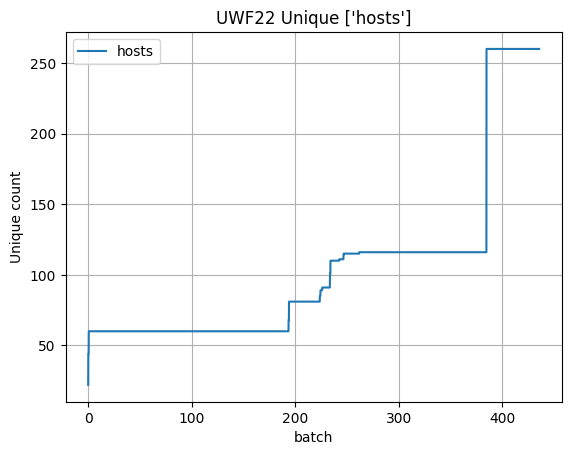

In [15]:
df = pd.read_parquet("UWF22_keywordmap_percent.parquet")
plot_hosts_no_stage(df, ["hosts"])

<Figure size 1000x500 with 0 Axes>

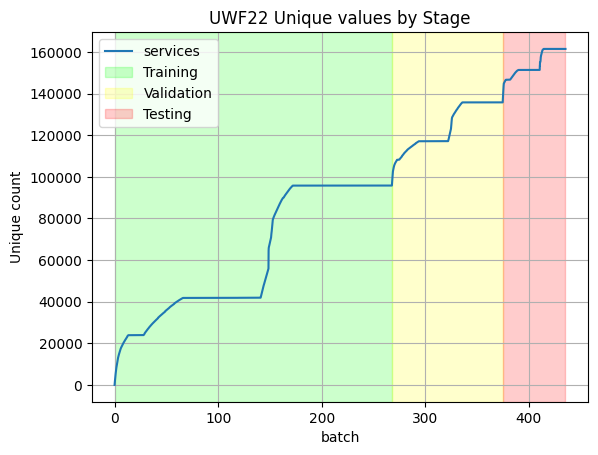

In [14]:
plot_hosts_with_stage(df, ["services"])